# Understanding GPT-2 ("next token prediction")

**2025/03/26**

* <mark>**Download na: C:\Users\kotzeje\.cache\huggingface\hub\models--gpt2**</mark>

* https://huggingface.co/openai-community/gpt2
    * This is the smallest version of GPT-2, with 124M parameters.
* https://huggingface.co/openai-community/gpt2-large
    * GPT-2 Large is the 774M parameter version of GPT-2
* https://huggingface.co/openai-community/gpt2-xl
    * GPT-2 XL is the 1.5B parameter version of GPT-2
 
****

 * https://huggingface.co/EleutherAI/gpt-neo-2.7B
    * **GPT-Neo 2.7B is a transformer model designed using EleutherAI's replication of the GPT-3 architecture.**

In [1]:
import torch
print(torch.__version__)
import transformers
print(transformers.__version__)

2.2.2+cu121
4.46.2


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## gpt/gpt-small

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
# You can use "gpt2-medium", "gpt2-large", "gpt2-xl" for larger models
model_name = "gpt2"  

model_name = r"D:\Data\huggingface\models\openai-community\openai-gpt2-small"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval();

In PyTorch, `model.eval()` is a method that switches a neural network model (like GPT-2 in your code) to evaluation mode. This doesn't change the model's weights or structure but `adjusts how certain layers behave during inference (prediction) compared to training`. 

In [4]:
# Count the number of parameters: 124M
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: {model_name}")
print(f"Number of parameters: {num_params:,}")

Model: D:\Data\huggingface\models\openai-community\openai-gpt2-small
Number of parameters: 124,439,808


In [5]:
def show_tokens(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)  # Move input to GPU/CPU

    # Show input tokenization
    input_token_ids = input_ids[0].tolist()  # Convert tensor to list of token IDs
    input_tokens = [tokenizer.decode([token_id]) for token_id in input_token_ids]

    print(f"Input string: '{input_text}'")
    print("Tokenized into IDs:", input_token_ids)
    print("Decoded tokens:", input_tokens)
    print()

    # Generate predictions
    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits
    
    # Get the last token's predictions (logits for next token)
    last_token_logits = predictions[0, -1, :]
    
    # Get top 10 predicted tokens
    top_k = 10
    top_token_ids = torch.topk(last_token_logits, top_k).indices
    top_token_probs = torch.softmax(last_token_logits, dim=-1)[top_token_ids]
    
    # Decode tokens and prepare results
    results = []
    for token_id, prob in zip(top_token_ids, top_token_probs):
        token = tokenizer.decode(token_id)
        results.append((token_id.item(), token, prob.item()))
    
    # Print results
    print(f"Top {top_k} predicted token IDs following '{input_text}':")
    for i, (token_id, token, prob) in enumerate(results, 1):
        print(f"{i}. Token ID: {token_id:<5} Token: '{token:<10}' Probability: {prob:.4f}")    

In [6]:
# Input sequence
input_text = "one, two, three,"
show_tokens(input_text)

Input string: 'one, two, three,'
Tokenized into IDs: [505, 11, 734, 11, 1115, 11]
Decoded tokens: ['one', ',', ' two', ',', ' three', ',']

Top 10 predicted token IDs following 'one, two, three,':
1. Token ID: 1440  Token: ' four     ' Probability: 0.6087
2. Token ID: 1936  Token: ' five     ' Probability: 0.0768
3. Token ID: 290   Token: ' and      ' Probability: 0.0528
4. Token ID: 2237  Token: ' six      ' Probability: 0.0349
5. Token ID: 393   Token: ' or       ' Probability: 0.0273
6. Token ID: 1115  Token: ' three    ' Probability: 0.0267
7. Token ID: 734   Token: ' two      ' Probability: 0.0123
8. Token ID: 3624  Token: ' eight    ' Probability: 0.0093
9. Token ID: 530   Token: ' one      ' Probability: 0.0088
10. Token ID: 257   Token: ' a        ' Probability: 0.0083


D:\Python\OpenAILangChain\lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:545: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


The difference in how "one", " two", and " three" are tokenized—with spaces before " two" and " three" but not "one"—is a result of how `GPT-2’s Byte-Pair Encoding (BPE)` tokenizer works. " two" <> "two"

In [8]:
# Test individual words
for word in ["one", "two", " two", "two,"]:
    token_ids = tokenizer.encode(word)
    decoded = tokenizer.decode(token_ids[0])
    print(f"Word: '{word}' → Token ID: {token_ids[0]} → Decoded: '{decoded}'")

Word: 'one' → Token ID: 505 → Decoded: 'one'
Word: 'two' → Token ID: 11545 → Decoded: 'two'
Word: ' two' → Token ID: 734 → Decoded: ' two'
Word: 'two,' → Token ID: 11545 → Decoded: 'two'


* tokenizer.encode("one") → [505] (no space)
* tokenizer.encode("two") → [11545] (no space, a different token ID)
* tokenizer.encode(" two") → [734] (with space)
* tokenizer.encode("two") → [11545] (with comma)

## Cleanup

In [9]:
import gc  # Garbage collection module

In [10]:
# Function to clean up memory
def cleanup_torch():
    # Clear GPU cache if using CUDA
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()  # Collect inter-process communication memory
    
    # Force garbage collection for CPU RAM
    gc.collect()

In [11]:
# Explicitly delete large objects
del model
del tokenizer

In [12]:
# Clean up memory
cleanup_torch()

print("\nMemory cleanup completed.")


Memory cleanup completed.


## gpt-large

https://huggingface.co/openai-community/gpt2-large

In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model_name = r"D:\Data\huggingface\models\openai-community\openai-gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.eval();

In [14]:
# Count the number of parameters: 774M
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: {model_name}")
print(f"Number of parameters: {num_params:,}")

Model: D:\Data\huggingface\models\openai-community\openai-gpt2-large
Number of parameters: 774,030,080


In [15]:
# Input sequence
input_text = "one, two, three,"
show_tokens(input_text)

Input string: 'one, two, three,'
Tokenized into IDs: [505, 11, 734, 11, 1115, 11]
Decoded tokens: ['one', ',', ' two', ',', ' three', ',']

Top 10 predicted token IDs following 'one, two, three,':
1. Token ID: 1440  Token: ' four     ' Probability: 0.5132
2. Token ID: 393   Token: ' or       ' Probability: 0.0905
3. Token ID: 290   Token: ' and      ' Probability: 0.0767
4. Token ID: 3503  Token: ' etc      ' Probability: 0.0442
5. Token ID: 1936  Token: ' five     ' Probability: 0.0170
6. Token ID: 530   Token: ' one      ' Probability: 0.0074
7. Token ID: 772   Token: ' even     ' Probability: 0.0070
8. Token ID: 257   Token: ' a        ' Probability: 0.0057
9. Token ID: 734   Token: ' two      ' Probability: 0.0054
10. Token ID: 2237  Token: ' six      ' Probability: 0.0053


## How did language models go from predicting the next word token to answering long, complex prompts? 

Read: https://www.reddit.com/r/learnmachinelearning/comments/17gd8mi/how_did_language_models_go_from_predicting_the/

I would argue the exact moment instructGPT (https://arxiv.org/abs/2203.02155) was introduced....

 This is the backbone of GPT 3.5 (aka ChatGPT). It's a multi-stage process, but the gist of it this:

    * the raw next-token predictor (GPT 3) outputs multiple answers for each question in a database

    * for each question, humans rank the answers

    * GPT 3 is fine-tuned to prefer the higher-ranked answers.

This technique is called RLHF (Reinforcement Learning from Human Feedback).

I also think this is the main differentiator between transformers which did <mark>"just next-token prediction" (eg the GPT 1,2,3)</mark> and the <mark>"conversational models" (eg. GPT 3.5, 4, Claude)</mark> you can see now.

## GPT-neo

In [17]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer  # Note: GPT-Neo uses GPT2Tokenizer

In [18]:
# Explicitly delete large objects
del model
del tokenizer

In [19]:
# Clean up memory
cleanup_torch()
print("\nMemory cleanup completed.")


Memory cleanup completed.


In [20]:
# Function to get GPU memory usage
def get_gpu_memory():
    return torch.cuda.memory_allocated() / 1024**2, torch.cuda.max_memory_allocated() / 1024**2

In [21]:
initial_used, initial_peak = get_gpu_memory()
print(f"Initial GPU memory used: {initial_used:.2f} MB, Peak: {initial_peak:.2f} MB")

Initial GPU memory used: 8.75 MB, Peak: 3074.67 MB


In [22]:
# loads a 11GB file, be patient...

#model_name = r"D:\Data\huggingface\models\EleutherAI\gpt-neo-2.7B"
model_name = r"C:\models\EleutherAI\gpt-neo-2.7B"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPTNeoForCausalLM.from_pretrained(model_name).to(device)
model.eval();

In [23]:
# GPU Memory usage after loading model: 10GB!!!
model_loaded_used, model_loaded_peak = get_gpu_memory()
print(f"GPU memory used after loading model: {model_loaded_used:.2f} MB, Peak: {model_loaded_peak:.2f} MB")

GPU memory used after loading model: 10378.70 MB, Peak: 10378.70 MB


In [24]:
# Count the number of parameters: 2.6B
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: {model_name}")
print(f"Number of parameters: {num_params:,}")

Model: C:\models\EleutherAI\gpt-neo-2.7B
Number of parameters: 2,651,307,520


In [27]:
# Input sequence
input_text = "one, two, three, five,"
show_tokens(input_text)

Input string: 'one, two, three, five,'
Tokenized into IDs: [505, 11, 734, 11, 1115, 11, 1936, 11]
Decoded tokens: ['one', ',', ' two', ',', ' three', ',', ' five', ',']

Top 10 predicted token IDs following 'one, two, three, five,':
1. Token ID: 3598  Token: ' seven    ' Probability: 0.3162
2. Token ID: 2237  Token: ' six      ' Probability: 0.2400
3. Token ID: 290   Token: ' and      ' Probability: 0.1036
4. Token ID: 3478  Token: ' ten      ' Probability: 0.0566
5. Token ID: 3624  Token: ' eight    ' Probability: 0.0471
6. Token ID: 393   Token: ' or       ' Probability: 0.0396
7. Token ID: 530   Token: ' one      ' Probability: 0.0277
8. Token ID: 3503  Token: ' etc      ' Probability: 0.0229
9. Token ID: 5193  Token: ' nine     ' Probability: 0.0172
10. Token ID: 1440  Token: ' four     ' Probability: 0.0118


### Generate Text Instead of Just Predicting Tokens

In [28]:
# After loading model and tokenizing input
model.to("cuda")
input_ids = tokenizer.encode("one, two, three,", return_tensors="pt").to("cuda")

# Generate text
with torch.no_grad():
    output_ids = model.generate(
        input_ids,
        max_length=20,  # Total tokens (input + generated)
        do_sample=True,  # Random sampling for variety
        top_k=50,        # Consider top 50 tokens
        temperature=0.1  # Control randomness (0.1 very strict)
    )
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(f"Generated text: '{generated_text}'")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated text: 'one, two, three, four, five, six, seven, eight, nine, ten,'


### Visualize Token Probability Distribution

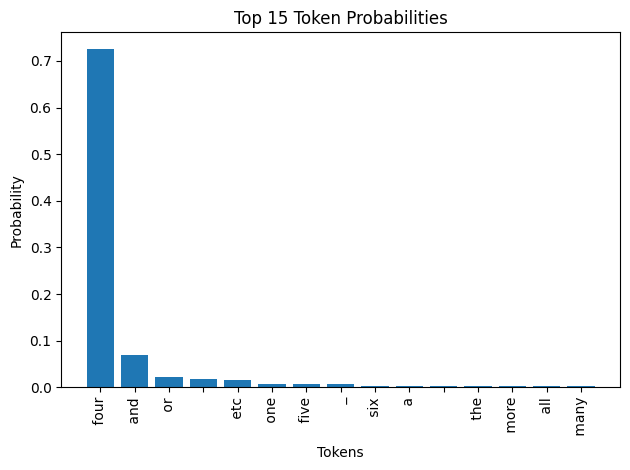

In [38]:
import matplotlib.pyplot as plt

model.to("cuda")
input_ids = tokenizer.encode("one, two, three,", return_tensors="pt").to("cuda")
with torch.no_grad():
    predictions = model(input_ids).logits[0, -1, :]
probs = torch.softmax(predictions, dim=-1)
top_k = 15
top_vals, top_ids = torch.topk(probs, top_k)

# Plot
plt.bar(range(top_k), top_vals.cpu().numpy())
plt.xticks(range(top_k), [tokenizer.decode([tid]) for tid in top_ids], rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Probability")
plt.title(f"Top {top_k} Token Probabilities")
plt.tight_layout()
plt.show()

### Measure Inference Speed (across batches)

In [32]:
import time

model.to("cuda")
batch_sizes = [1, 4, 8, 16]

for bs in batch_sizes:
    input_ids = tokenizer.encode("one, two, three,", return_tensors="pt").repeat(bs, 1).to("cuda")
    start = time.time()
    with torch.no_grad():
        model(input_ids)
        
    elapsed = time.time() - start
    print(f"Batch size {bs}: {elapsed:.4f} seconds ({bs/elapsed:.2f} sequences/sec)")

Batch size 1: 0.2472 seconds (4.05 sequences/sec)
Batch size 4: 0.0542 seconds (73.85 sequences/sec)
Batch size 8: 0.0290 seconds (275.84 sequences/sec)
Batch size 16: 0.0311 seconds (513.82 sequences/sec)


### Explore Attention Weights

What This Does

    Sliding Window:
        Takes 3-token chunks: "one, two", "two, three", "three,".
        For each window, it runs the model to get attention weights and the top predicted token.
    Attention Extraction:
        outputs.attentions[-1] grabs the last layer’s attention (most meaningful for final predictions).
        [0, -1, :, -1] gets the attention scores for the last token in the window predicting the next one.
    Comparison:
        Also shows attention for the full sequence ("one, two, three,")

In [33]:
# Input sequence
input_text = "one, two, three,"
input_ids = tokenizer.encode(input_text, return_tensors="pt").to("cuda")
tokens = [tokenizer.decode([tid]) for tid in input_ids[0]]
print(input_ids)
print(tokens)
print(75*'*')

# Full sequence attention
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)
    attentions = outputs.attentions[-1]  # Last layer's attention
    print(f"Attention tensor shape: {attentions.shape}")  # Debug shape

    # Average across all attention heads for the last token's attention
    last_token_attention = attentions[0, :, -1, :].mean(dim=0)  # [batch, heads, query, key] -> mean over heads

# Print full sequence attention
print(f"\nFull sequence: {input_text}")
print("Attention weights:")
for token, attn in zip(tokens, last_token_attention):
    print(f"  '{token:<10}': {attn.item():.4f}")
print(f"Sum of attention weights: {last_token_attention.sum().item():.4f}")
print("last_token_attention.sum() should be close to 1, confirming proper normalization.")

tensor([[ 505,   11,  734,   11, 1115,   11]], device='cuda:0')
['one', ',', ' two', ',', ' three', ',']
***************************************************************************
Attention tensor shape: torch.Size([1, 20, 6, 6])

Full sequence: one, two, three,
Attention weights:
  'one       ': 0.6749
  ',         ': 0.0093
  ' two      ': 0.0133
  ',         ': 0.0240
  ' three    ': 0.0187
  ',         ': 0.2599
Sum of attention weights: 1.0000
last_token_attention.sum() should be close to 1, confirming proper normalization.


In [34]:
# Slide a 3-token window and analyze attention
window_size = 3
for i in range(len(input_ids[0]) - window_size + 1):
    window_ids = input_ids[:, i:i + window_size]
    window_tokens = tokens[i:i + window_size]
    
    with torch.no_grad():
        outputs = model(window_ids, output_attentions=True)
        attentions = outputs.attentions[-1]
        last_token_attention = attentions[0, :, -1, :].mean(dim=0)
    
    top_id = torch.argmax(outputs.logits[0, -1, :]).item()
    top_token = tokenizer.decode(top_id)
    
    print(f"\nWindow {i + 1}: {' '.join(window_tokens)}")
    print("Attention weights:")
    for token, attn in zip(window_tokens, last_token_attention):
        print(f"  '{token:<10}': {attn.item():.4f}")
    print(f"Predicted next token: '{top_token}'")
    print(f"Sum of attention weights: {last_token_attention.sum().item():.4f}")
    print("last_token_attention.sum() should be close to 1, confirming proper normalization.")


Window 1: one ,  two
Attention weights:
  'one       ': 0.6900
  ',         ': 0.0042
  ' two      ': 0.3058
Predicted next token: ','
Sum of attention weights: 1.0000
last_token_attention.sum() should be close to 1, confirming proper normalization.

Window 2: ,  two ,
Attention weights:
  ',         ': 0.6890
  ' two      ': 0.0468
  ',         ': 0.2642
Predicted next token: ' three'
Sum of attention weights: 1.0000
last_token_attention.sum() should be close to 1, confirming proper normalization.

Window 3:  two ,  three
Attention weights:
  ' two      ': 0.6926
  ',         ': 0.0126
  ' three    ': 0.2948
Predicted next token: ','
Sum of attention weights: 1.0000
last_token_attention.sum() should be close to 1, confirming proper normalization.

Window 4: ,  three ,
Attention weights:
  ',         ': 0.6947
  ' three    ': 0.0492
  ',         ': 0.2562
Predicted next token: ' four'
Sum of attention weights: 1.0000
last_token_attention.sum() should be close to 1, confirming proper n